In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/perrin-freres-monthly-champagne-sales/perrin-freres-monthly-champagne.csv


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
df=pd.read_csv("../input/perrin-freres-monthly-champagne-sales/perrin-freres-monthly-champagne.csv")

In [25]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [26]:
df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


<AxesSubplot:>

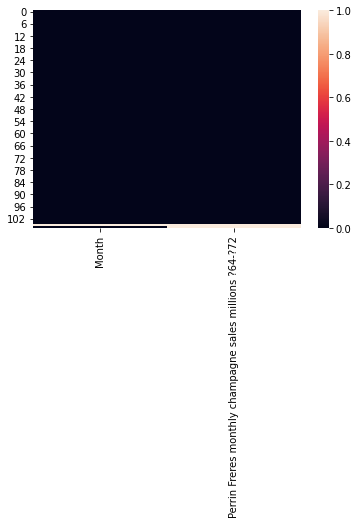

In [27]:
#From the tail of the data set 2 rows seems to have NaN values. 
#To be sure about all the values seaborn heatmap can be used for easy visualisation.

sns.heatmap(df[['Month', 'Perrin Freres monthly champagne sales millions ?64-?72',]].isnull())

In [28]:
#Drop Row 104 and 106 to remove Nan values

df.drop(df.index[[105,106]],axis=0,inplace=True)

In [29]:
df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [30]:
#Giving simpler name for column

df.columns=["Month","Sales"]


In [31]:
#To change month to pandas recognizable date

df['Month']=pd.to_datetime(df['Month'])


In [32]:
df.set_index('Month', inplace=True)


In [33]:
# Use describe to check the data critical values

df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


<AxesSubplot:xlabel='Month'>

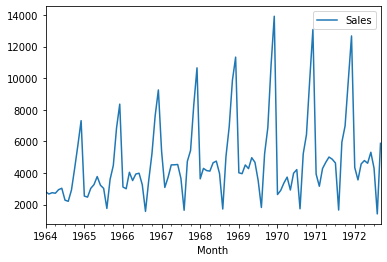

In [34]:
df.plot()

In [35]:
#To apply any time series model we need to have a stationary data (constant mean and Std dev)
#In case the data is not stationary we need to make it so by differenceing

#From the first look one can identify a seasonality in the data,
#To confirm this we use Dickyfuller test to find out if the data is stationary or not

#Dickey–Fuller test
#Ho: (Null hypothesis) series is not stationary
#H1: (Alternate hypothesis) series is stationary
#Test for stationarity: If the test statistic is greater than the critical value, we reject the null hypothesis (the series is not stationary).
#If the test statistic is less than the critical value, if fail to reject the null hypothesis (the series is stationary).

from statsmodels.tsa.stattools import adfuller

def adfuller_test(vals):
    result=adfuller(vals)
    labels = ['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
  
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis.")
    else:
        print("Weak evidence against null hypothesis, indicating it is non-stationary ")

adfuller_test(df["Sales"])

Test Statistic : -1.8335930563276228
p-value : 0.363915771660245
#Lags Used : 11
Number of Observations Used : 93
Weak evidence against null hypothesis, indicating it is non-stationary 


In [36]:
#To remove seasonaliy differencing is performed .12 is choosen because the of the yearly seasonaliy.

df['First Difference']=df['Sales']-df['Sales'].shift(12)

In [37]:
#Because we are shifting 12 values there will be 12 NaN values which will be removed
#and Dicky Fuller test is performed again

adfuller_test(df['First Difference'].dropna())


Test Statistic : -7.626619157213164
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
Strong evidence against the null hypothesis(Ho), reject the null hypothesis.


<AxesSubplot:xlabel='Month'>

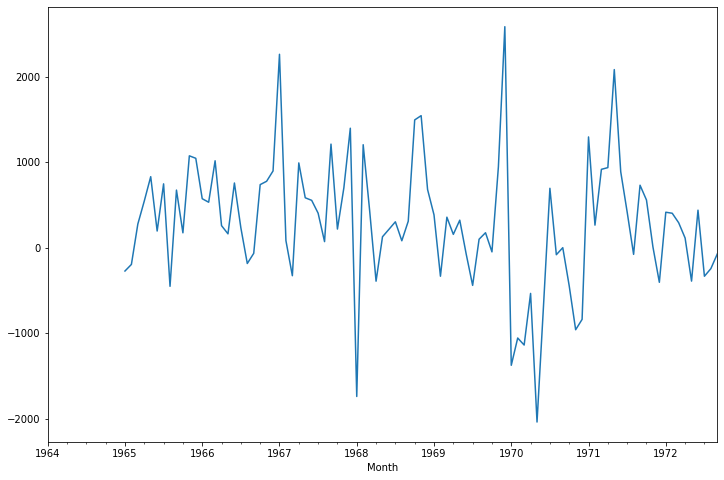

In [49]:
df['First Difference'].plot(figsize=(12,8))

In [39]:
#The plot shows there is no much of a seasonality in the data 

#Now ACF and PACF are ploted

#Once we determine the nature of the auto-correlations we use the following rules of thumb.

#Rule 1: If the ACF shows exponential decay, the PACF has a spike at lag 1,
#and no correlation for other lags, then use one autoregressive (p)parameter

#Rule 2: If the ACF shows a sine-wave shape pattern or a set of exponential decays, 
#the PACF has spikes at lags 1 and 2, and no correlation for other lags, the use two autoregressive (p) parameters

#Rule 3: If the ACF has a spike at lag 1, no correlation for other lags, 
#nd the PACF damps out exponentially, then use one moving average (q) parameter.

#Rule 4: If the ACF has spikes at lags 1 and 2, no correlation for other lags,
#and the PACF has a sine-wave shape pattern or a set of exponential decays, then use two moving average (q) parameter.

#Rule 5: If the ACF shows exponential decay starting at lag 1, and the PACF shows exponential decay starting at lag 1, 
#then use one autoregressive (p) and one moving average (q) parameter.

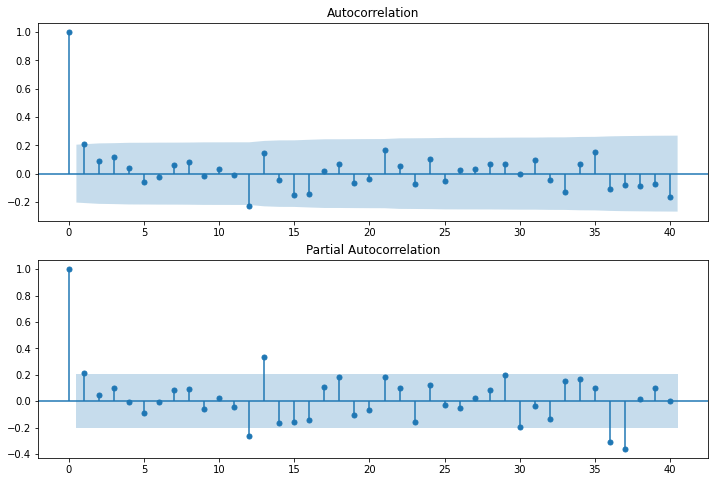

In [40]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['First Difference'].iloc[13:],lags=40,ax=ax2)

In [41]:

#ARIMA MODEL


#AR : Autoregression. 
#I  : Integrated.
#MA : Moving Average. 
    
#p  : The number of lag observations included in the model, also called the lag order.
#d  : The number of times that the raw observations are differenced, also called the degree of differencing.
#q  : The size of the moving average window, also called the order of moving average.

In [42]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df['Sales'],order=(1,1,1))
model_fit=model.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

In [43]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.263
Date:                Fri, 28 May 2021   AIC                           1910.251
Time:                        17:09:56   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7843     12.405      1.837      0.066      -1.530      47.098
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='Month'>

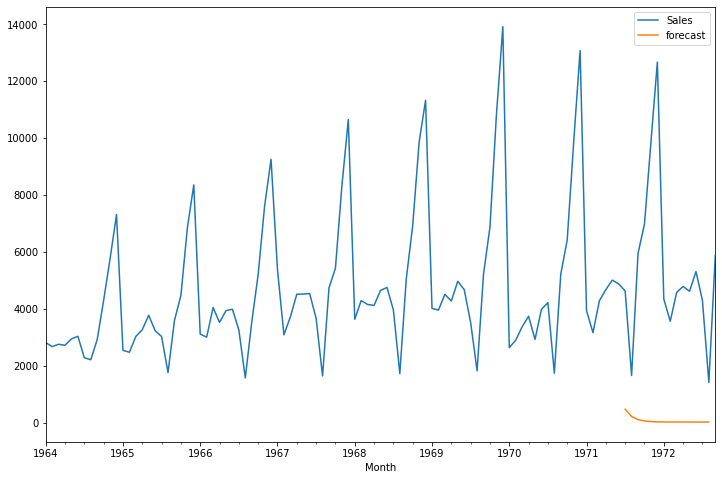

In [46]:
#using the ARIMA model to predict from row 90 to103
# Adding a new row 'forcast' for the predicted values 

predicted_values=model_fit.predict(start=90,end=103,dynamic=True)
df['forecast']=predicted_values
df[['Sales','forecast']].plot(figsize=(12,8))

In [ ]:
#The Forcasted values shown in the yellow lines looks out of position and illogical so we try SARIMA MODEL

#SARIMA MODEL
#Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly 
#supports univariate time series data with a seasonal component.

In [47]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<AxesSubplot:xlabel='Month'>

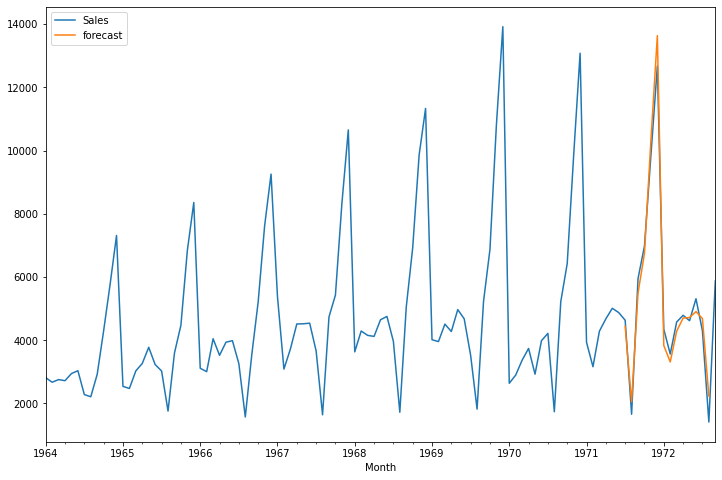

In [48]:
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))